## Optimizing a mathematical function using the GEO algorithm leveraging a VAE generative model

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else 'cpu'

### Cost Function

We will optimize a mathematical function f(x) = $\sqrt{x_1^4 + x_2^4 + x_3^4 + \dots + x_{10}^4}$


In [93]:
def objective(x):
    return torch.sqrt(torch.pow(x,4).sum(dim=1)).to(device)

### Initial Seed Dataset: generated randomly 

In [ ]:
initial_seed = torch.rand(1000,10) * 2 - 1
initial_seed = initial_seed.to(device)

### Obtaining a MultiVariate distribution from the seed dataset

In [95]:
def multiDistribution(data_seed):
  mean = torch.mean(data_seed, axis=0)
  covariance = torch.cov(torch.permute(data_seed, (1, 0)))
  distribution = MultivariateNormal(loc=mean, covariance_matrix=covariance)
  return distribution

### Defining the VAE generative model

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  
        self.fc22 = nn.Linear(hidden_dim, latent_dim) 

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  
        eps = torch.randn_like(std)  
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Sigmoid to get reconstructed output between [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  

def vae_loss(recon_x, x, mu, logvar):
    x = torch.clamp(x, 0.0, 1.0)  # This clips the values to be within [0, 1]

    # Binary Cross Entropy loss for reconstruction
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')  # Sum over the batch
    # KL Divergence loss between the learned distribution and standard normal distribution
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_div


#### Defining a utility function for generating random noise

In [97]:
def generate_random_noise(batch_size, sample_dim):
    return torch.randn(batch_size, sample_dim).to(device)

### Defining parameters, optimizer and loss function for the training

In [98]:
sample_dim = 10
latent_dim = 10
hidden_dim = 4
batch_size = 64
num_epochs = 500
learning_rate = 0.0002

vae = VAE(sample_dim, hidden_dim, latent_dim).to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

### Applying the GEO algorithm to train our VAE

In [99]:
from tqdm import tqdm

pbar = tqdm(range(num_epochs))
new_samples = np.array([])
initial_seed_obj = objective(initial_seed)
ground_val = initial_seed_obj.min().item()
distri = multiDistribution(initial_seed)
costs = []
means = []
stds = []

for epoch in pbar:
    if epoch > 0:
        # Sort generated samples by objective function values
        generated_samples = vae.decode(torch.randn(100, latent_dim).to(device)).detach()
        objective_values = objective(generated_samples)
        
        # Select top 25% of samples with highest objective values
        top_indices = torch.topk(objective_values, k=50).indices
        top_samples = generated_samples[top_indices]
        
        # Update initial seed with top samples and some randomness
        initial_seed = top_samples
        initial_seed = torch.cat([
            initial_seed, 
            # torch.rand(750, 5, device=device) * 2 - 1  # Add some randomness
        ])
        
        # Recompute the objective and update the ground_val
        initial_seed_obj = objective(initial_seed)  # Recompute objective with new seed
        ground_val = initial_seed_obj.min().item()  # Update ground_val
        # print(ground_val)

    mean, std = torch.mean(initial_seed_obj), torch.std(initial_seed_obj)

    for batch_idx in range(1000 // batch_size):
        
        # Sample real data
        real_samples = distri.sample(sample_shape=[batch_size*10]).to(device).float()
        real_samples = real_samples[:batch_size, :]

        # Reset gradients
        vae_optimizer.zero_grad()

        # Encoding and decoding
        recon_samples, mu, logvar = vae(real_samples)

        # Compute VAE loss
        loss = vae_loss(recon_samples, real_samples, mu, logvar)

        # Backpropagate and optimize VAE
        loss.backward()
        vae_optimizer.step()

    # Generate new samples using VAE decoder
    new_samples = vae.decode(torch.randn(100, latent_dim).to(device)).detach()

    pbar.set_description(f"{round(loss.item(), 2)} :: {round(mean.item(), 2)} :: {round(std.item(), 2)} :: {ground_val}")
    
    costs.append(ground_val)
    means.append(mean.item())
    stds.append(std.item())


331.49 :: 0.17 :: 0.0 :: 0.16368983685970306: 100%|██████████| 500/500 [00:18<00:00, 27.29it/s] 


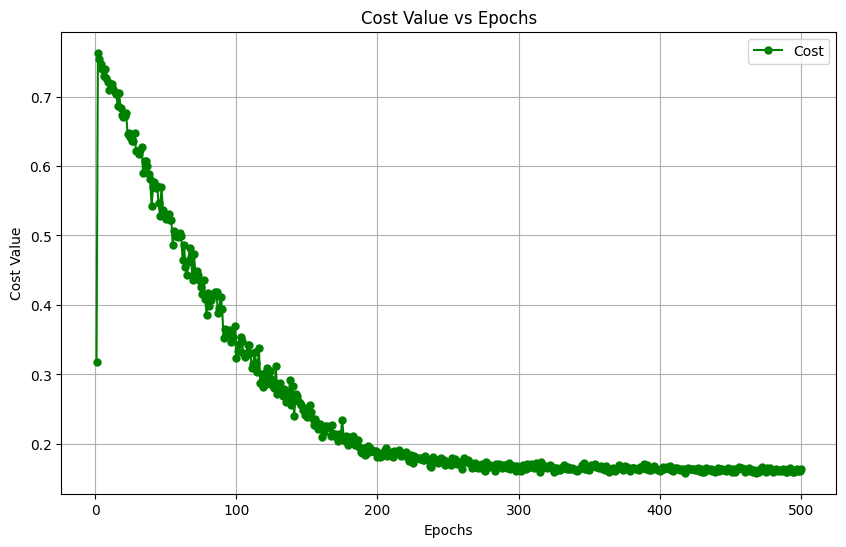

In [106]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1)) 
cost_values = costs 

plt.figure(figsize=(10, 6))  
plt.plot(epochs, cost_values, label='Cost', color='green', marker='o', linestyle='-', markersize=5)

plt.xlabel('Epochs')
plt.ylabel('Cost Value')
plt.title('Cost Value vs Epochs')

plt.grid(True)
plt.legend()
plt.show(block=True)
